In [1]:
import warnings
warnings.filterwarnings('ignore')

# Data Preprocessing and Cleaning

In [2]:
from pathlib import Path
import imghdr
import os

data_dir = "Plant Disease Recognition Dataset"
image_extensions = [".png", ".jpg"]  # add all your image file extensions here

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]

for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        if filepath.exists():  # Check if the file exists before opening it
            img_type = imghdr.what(filepath)
            if img_type is None:
                print(f"{filepath} is not an image")
                os.remove(filepath)
            elif img_type not in img_type_accepted_by_tf:
                print(f"{filepath} is a {img_type}, not accepted by TensorFlow")
                os.remove(filepath)
        else:
            print(f"{filepath} does not exist.")

# Data Loading and Splitting

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

image_size = (224, 224)
batch_size = 32

# Load your dataset using ImageDataGenerator
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "Plant Disease Recognition Dataset/Train",
    image_size=image_size,
    batch_size=batch_size,
    labels='inferred',
    label_mode='categorical'
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "Plant Disease Recognition Dataset/Validation",
    image_size=image_size,
    batch_size=batch_size,
    labels='inferred',
    label_mode='categorical',
)

Found 1322 files belonging to 3 classes.
Found 60 files belonging to 3 classes.


In [4]:
class_names = train_ds.class_names

# Count the number of samples per class in the training set
for class_name in class_names:
    num_samples = len([filename for filename in train_ds.file_paths if class_name in filename])
    print(f"Number of {class_name} samples in the training set: {num_samples}")

print()

# Count the number of samples per class in the validation set
for class_name in class_names:
    num_samples = len([filename for filename in val_ds.file_paths if class_name in filename])
    print(f"Number of {class_name} samples in the validation set: {num_samples}")

Number of Healthy samples in the training set: 458
Number of Powdery samples in the training set: 430
Number of Rust samples in the training set: 434

Number of Healthy samples in the validation set: 20
Number of Powdery samples in the validation set: 20
Number of Rust samples in the validation set: 20


# Visualization of Training Data

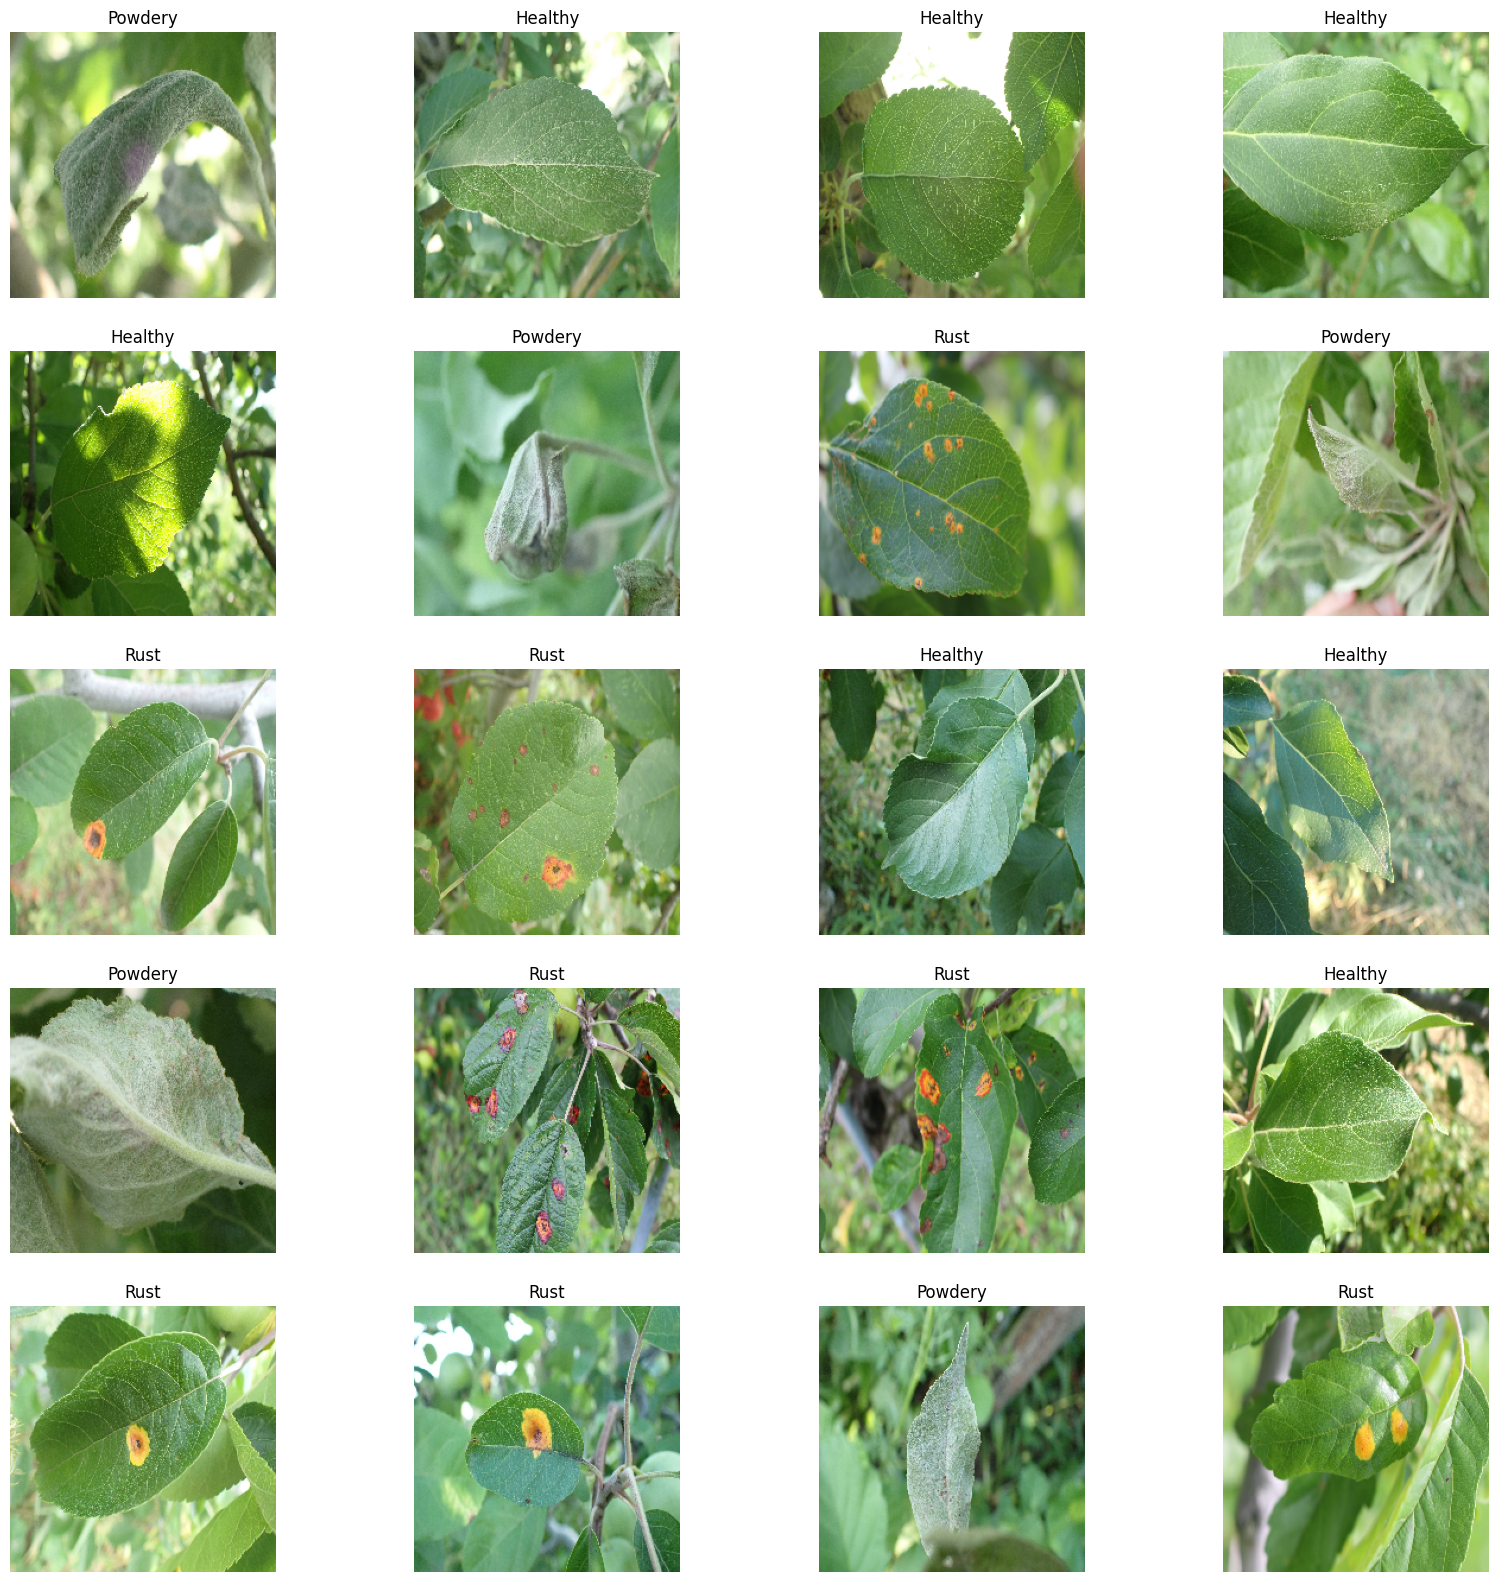

In [5]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(20, 20))
for images, labels in train_ds.take(1):
    for i in range(20):
        ax = plt.subplot(5,4,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(labels[i].numpy())])
        plt.axis("off")
plt.show()

# Model Architecture

Adding max pooling layers helps reduce the spatial dimensions and control overfitting.

In [6]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

# Load ResNet50 as a base model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the pre-trained base model
base_model.trainable = False

# Create your custom model
inputs = tf.keras.Input(shape=(224, 224, 3))
resnet_input = preprocess_input(inputs)

# Include the output of the ResNet50 base model
base_model_output = base_model(resnet_input)

# Global average pooling
x = layers.GlobalAveragePooling2D()(base_model_output)

# Additional dense layers
x = layers.Dense(128)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.Dropout(0.5)(x)

# Output layer
outputs = layers.Dense(3, activation="softmax")(x)

# Create the final model
model = Model(inputs=inputs, outputs=outputs)

# Print the model summary
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (  (None, 224, 224, 3)       0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 224, 224, 3)       0         
 )                                                               
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                             

# Visualizing Model Architecture

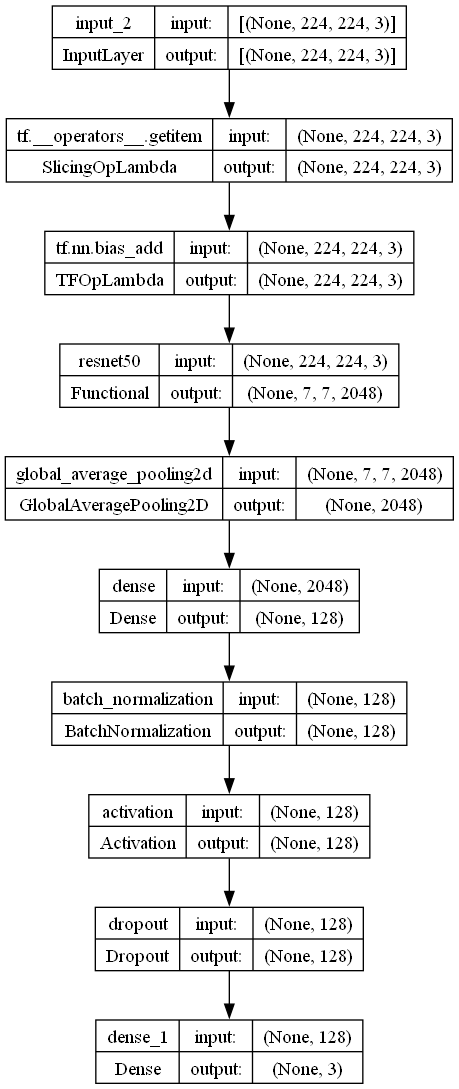

In [7]:
tf.keras.utils.plot_model(model, to_file='d_trial3.png', show_shapes=True)

# Display Model Summary

In [8]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (  (None, 224, 224, 3)       0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 224, 224, 3)       0         
 )                                                               
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                             

# Model Training

In [9]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

# Define a learning rate scheduler
def lr_scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

epochs = 50

early_stopping = EarlyStopping(
    monitor='val_loss',  # Stop training when validation loss does not improve
    patience=5,           # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

custom_optimizer = Adam(learning_rate=0.005)

model.compile(
    optimizer=custom_optimizer,
    loss="categorical_crossentropy",
    metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()],
)

# Training the Model

In [10]:
history = model.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=[early_stopping, LearningRateScheduler(lr_scheduler)])

Epoch 1/50
42/42 [==============================] - 900s 19s/step - loss: 0.1843 - accuracy: 0.9380 - precision: 0.9448 - recall: 0.9319 - auc: 0.9905 - val_loss: 0.0761 - val_accuracy: 0.9667 - val_precision: 0.9831 - val_recall: 0.9667 - val_auc: 0.9989 - lr: 0.0050
Epoch 2/50
42/42 [==============================] - 804s 18s/step - loss: 0.0661 - accuracy: 0.9818 - precision: 0.9826 - recall: 0.9811 - auc: 0.9983 - val_loss: 0.0398 - val_accuracy: 0.9833 - val_precision: 0.9831 - val_recall: 0.9667 - val_auc: 0.9996 - lr: 0.0050
Epoch 3/50
42/42 [==============================] - 769s 18s/step - loss: 0.0404 - accuracy: 0.9887 - precision: 0.9901 - recall: 0.9864 - auc: 0.9995 - val_loss: 0.0523 - val_accuracy: 0.9667 - val_precision: 0.9667 - val_recall: 0.9667 - val_auc: 0.9994 - lr: 0.0050
Epoch 4/50
42/42 [==============================] - 557s 13s/step - loss: 0.0435 - accuracy: 0.9864 - precision: 0.9871 - recall: 0.9856 - auc: 0.9994 - val_loss: 0.0513 - val_accuracy: 0.9667 

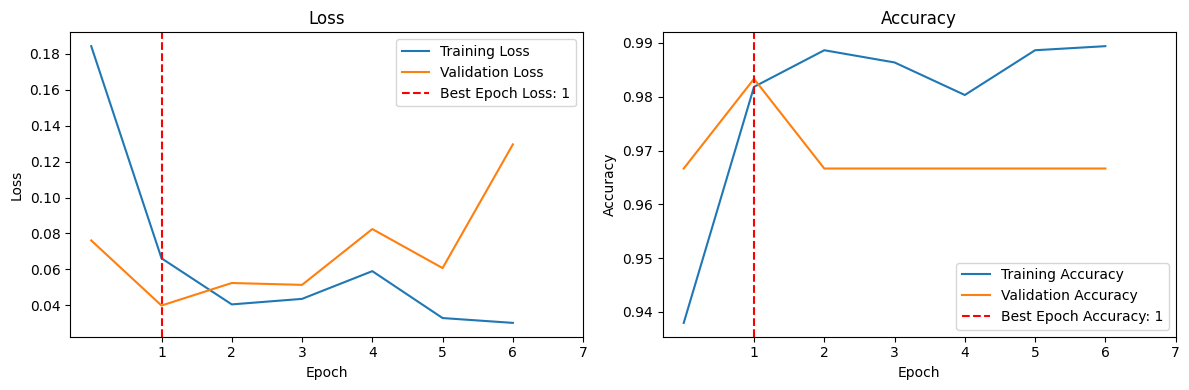

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Plot training history for loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Mark the best epoch for validation loss
best_epoch_loss = np.argmin(history.history['val_loss'])
plt.axvline(x=best_epoch_loss, color='r', linestyle='--', label=f'Best Epoch Loss: {best_epoch_loss}')
plt.legend()

# Set x-axis ticks to start from 1
plt.xticks(np.arange(1, len(history.history['loss']) + 1, 1))

# Plot training history for accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Mark the best epoch for validation accuracy
best_epoch_accuracy = np.argmax(history.history['val_accuracy'])
plt.axvline(x=best_epoch_accuracy, color='r', linestyle='--', label=f'Best Epoch Accuracy: {best_epoch_accuracy}')
plt.legend()

# Set x-axis ticks to start from 1
plt.xticks(np.arange(1, len(history.history['accuracy']) + 1, 1))

plt.tight_layout()
plt.show()


In [12]:
# Print the best epochs
print(f'Best Epoch for Validation Loss: {best_epoch_loss}')
print(f'Best Epoch for Validation Accuracy: {best_epoch_accuracy}')

Best Epoch for Validation Loss: 1
Best Epoch for Validation Accuracy: 1


# Model Testing and Evaluation

In [13]:
# Load and test an image of curly hair
'''
img_curly = keras.preprocessing.image.load_img(
    "hair_types/Curly_Hair/02dac897d1dec9ba8c057a11d041ada8--layered-natural-hair-natural-black-hairstyles.jpg", target_size=image_size
)
img_array_curly = keras.preprocessing.image.img_to_array(img_curly)
img_array_curly = tf.expand_dims(img_array_curly, 0)  # Create batch axis

predictions_curly = model.predict(img_array_curly)
print(
    "CURLY: This image is %.2f percent curly hair, %.2f percent straight hair, and %.2f percent wavy hair."
    % tuple(predictions_curly[0])
)

# Load and test an image of straight hair
img_straight = keras.preprocessing.image.load_img(
    "hair_types/Straight_Hair/1-short-spiky-mens-haircut.jpg", target_size=image_size
)
img_array_straight = keras.preprocessing.image.img_to_array(img_straight)
img_array_straight = tf.expand_dims(img_array_straight, 0)  # Create batch axis

predictions_straight = model.predict(img_array_straight)
print(
    "STRAIGHT: This image is %.2f percent curly hair, %.2f percent straight hair, and %.2f percent wavy hair."
    % tuple(predictions_straight[0])
)

# Load and test an image of wavy hair
img_wavy = keras.preprocessing.image.load_img(
    "hair_types/Wavy_Hair/2-Short-High-Volume-Hairstyle.jpg", target_size=image_size
)
img_array_wavy = keras.preprocessing.image.img_to_array(img_wavy)
img_array_wavy = tf.expand_dims(img_array_wavy, 0)  # Create batch axis

predictions_wavy = model.predict(img_array_wavy)
print(
    "WAVY: This image is %.2f percent curly hair, %.2f percent straight hair, and %.2f percent wavy hair."
    % tuple(predictions_wavy[0])
)
'''

'\nimg_curly = keras.preprocessing.image.load_img(\n    "hair_types/Curly_Hair/02dac897d1dec9ba8c057a11d041ada8--layered-natural-hair-natural-black-hairstyles.jpg", target_size=image_size\n)\nimg_array_curly = keras.preprocessing.image.img_to_array(img_curly)\nimg_array_curly = tf.expand_dims(img_array_curly, 0)  # Create batch axis\n\npredictions_curly = model.predict(img_array_curly)\nprint(\n    "CURLY: This image is %.2f percent curly hair, %.2f percent straight hair, and %.2f percent wavy hair."\n    % tuple(predictions_curly[0])\n)\n\n# Load and test an image of straight hair\nimg_straight = keras.preprocessing.image.load_img(\n    "hair_types/Straight_Hair/1-short-spiky-mens-haircut.jpg", target_size=image_size\n)\nimg_array_straight = keras.preprocessing.image.img_to_array(img_straight)\nimg_array_straight = tf.expand_dims(img_array_straight, 0)  # Create batch axis\n\npredictions_straight = model.predict(img_array_straight)\nprint(\n    "STRAIGHT: This image is %.2f percent cu

In [14]:
val_loss, val_accuracy, val_precision, val_recall, val_auc = model.evaluate(val_ds)
print(f"Validation Accuracy: {val_accuracy}")
print(f"Validation Precision: {val_precision}")
print(f"Validation Recall: {val_recall}")
print(f"Validation AUC: {val_auc}")

2/2 [==============================] - 29s 11s/step - loss: 0.0398 - accuracy: 0.9833 - precision: 0.9831 - recall: 0.9667 - auc: 0.9996
Validation Accuracy: 0.9833333492279053
Validation Precision: 0.9830508232116699
Validation Recall: 0.9666666388511658
Validation AUC: 0.9995833039283752


In [15]:
import tensorflow as tf
from tensorflow import keras

# Assuming val_ds is your validation dataset
val_images = []
val_labels = []

for images, labels in val_ds.take(3):  # Take 3 batches (adjust as needed)
    val_images.append(images)
    val_labels.append(labels)

# Concatenate the batches to get the images and labels
val_images = tf.concat(val_images, axis=0)
val_labels = tf.concat(val_labels, axis=0)

# Test the model on the selected validation images
predictions = model.predict(val_images)

for i in range(len(val_images)):
    print(f"Image {i + 1}")
    print(f"True Label: {val_labels[i]}")
    print(f"Predictions: {predictions[i]}")
    print()


2/2 [==============================] - 42s 12s/step
Image 1
True Label: [0. 0. 1.]
Predictions: [6.2037225e-06 2.3001719e-06 9.9999154e-01]

Image 2
True Label: [1. 0. 0.]
Predictions: [9.9997032e-01 2.2196218e-05 7.4710788e-06]

Image 3
True Label: [0. 1. 0.]
Predictions: [1.4261096e-06 9.9999845e-01 1.7796738e-07]

Image 4
True Label: [0. 0. 1.]
Predictions: [7.5740725e-02 2.6761578e-05 9.2423254e-01]

Image 5
True Label: [1. 0. 0.]
Predictions: [0.80983657 0.18347894 0.00668439]

Image 6
True Label: [1. 0. 0.]
Predictions: [0.8703946  0.06292664 0.06667878]

Image 7
True Label: [1. 0. 0.]
Predictions: [0.92526805 0.03894588 0.03578607]

Image 8
True Label: [0. 1. 0.]
Predictions: [3.3373996e-07 9.9999905e-01 5.8830028e-07]

Image 9
True Label: [0. 1. 0.]
Predictions: [1.4965682e-05 9.9996173e-01 2.3253784e-05]

Image 10
True Label: [0. 1. 0.]
Predictions: [1.5598322e-06 9.9999833e-01 8.8814069e-08]

Image 11
True Label: [0. 1. 0.]
Predictions: [6.2039406e-05 9.9987555e-01 6.2457453e

In [22]:
def Prediction(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array((images[i].numpy()))
    img_array = tf.expand_dims(img_array,0)     # create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])),2)
    
    return predicted_class , confidence

Found 150 files belonging to 3 classes.


1/1 [==============================] - 1s 708ms/step


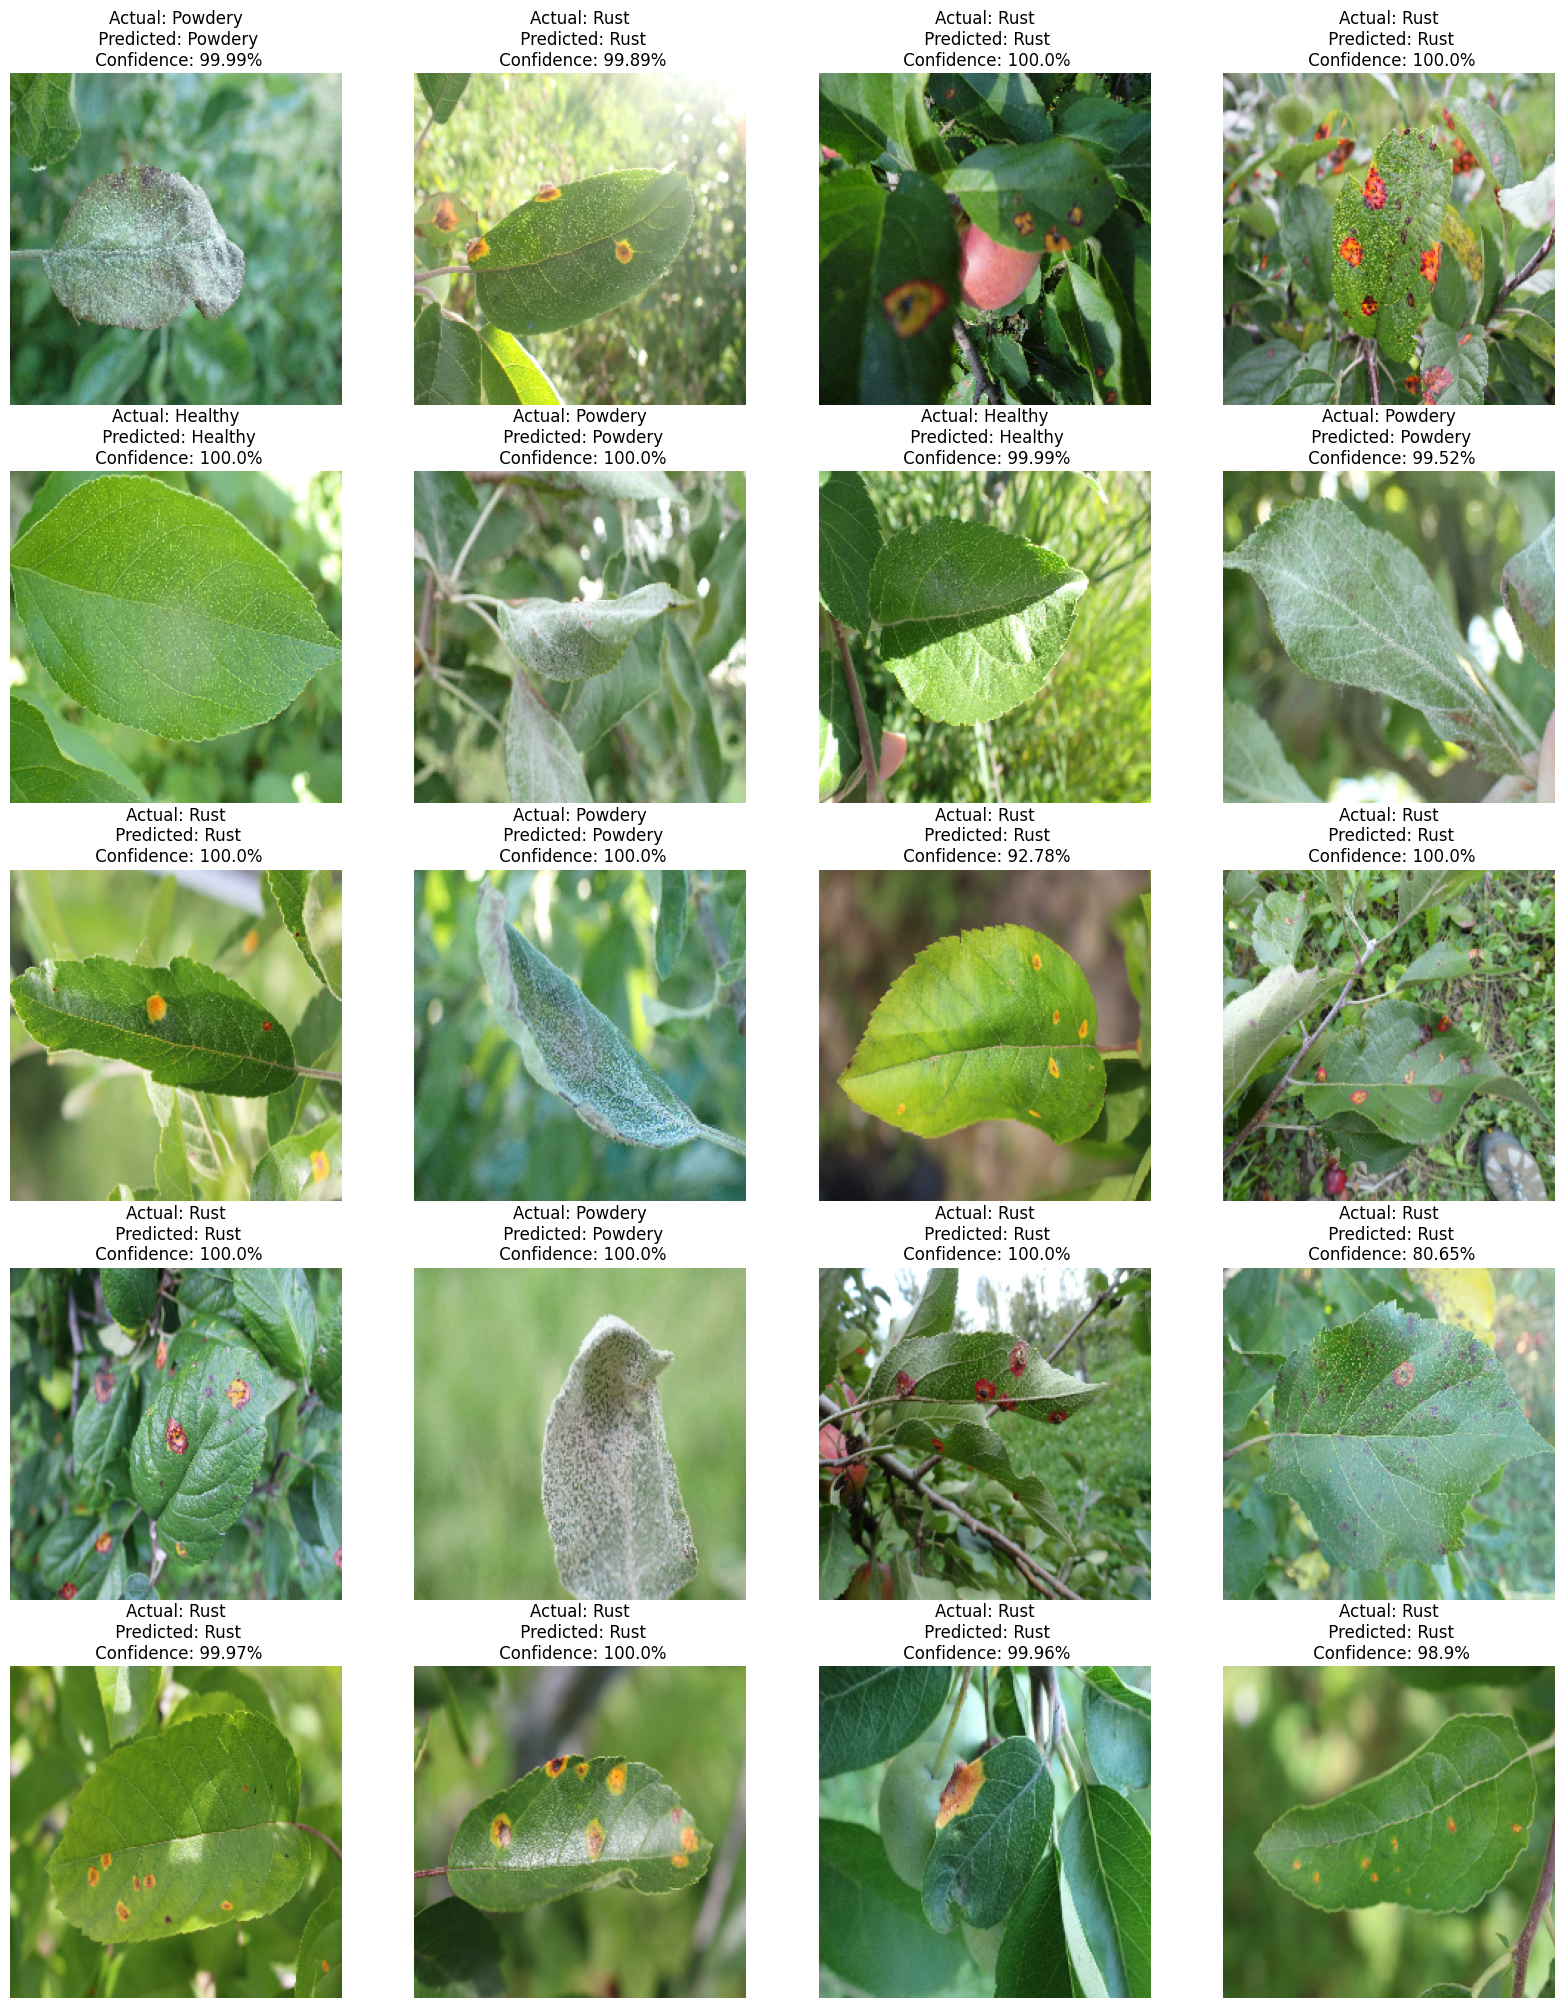

In [23]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "Plant Disease Recognition Dataset/Test",
    image_size=image_size,
    batch_size=batch_size,
    labels='inferred',
    label_mode='categorical',
)

plt.figure(figsize=(20, 25))
for images, labels in test_ds.take(1):
    for i in range(20):
        ax = plt.subplot(5, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        # Convert one-hot encoded label to an integer
        actual_class_index = np.argmax(labels[i])

        # Use the integer label to get the class name
        actual_class = class_names[actual_class_index]

        # Make predictions
        predicted_class, confidence = Prediction(model, images[i].numpy())

        plt.title(f"Actual: {actual_class}\n Predicted: {predicted_class}\n Confidence: {confidence}%")
        plt.axis("off")
